# Survival Classification Using mean-CBSO

## Importing libraries and packages

In [49]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import os

## Importing the dataset

In [50]:
%matplotlib inline
sns.set_style('whitegrid')
df = pd.read_csv(r'heart_failure_clinical_records_dataset.csv')
df.head(5)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [51]:
# Selecting only 3 highest correlated features (from random forest ranking and pearson correlation)
df = pd.DataFrame(df.iloc[:,[0,4,7,-1]])

In [52]:
# Appending the list of attributes to be used later when coupling- decoupling the dataframe
ListAttr = []
lengthOfList = len(df)
for i in df:
    print(i)
    ListAttr.append(i)
   


age
ejection_fraction
serum_creatinine
DEATH_EVENT


## Splitting the dataframe in train and test sets

In [53]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.iloc[:,:], test_size = 0.2, random_state = 0)
print(df_train)

      age  ejection_fraction  serum_creatinine  DEATH_EVENT
134  81.0                 35              1.18            0
145  50.0                 30              0.70            0
63   45.0                 35              1.00            1
292  52.0                 38              1.00            0
284  50.0                 40              0.80            0
..    ...                ...               ...          ...
251  55.0                 35              0.80            0
192  50.0                 40              0.70            0
117  85.0                 60              3.20            0
47   60.0                 38              0.60            1
172  70.0                 60              1.10            0

[239 rows x 4 columns]


## Scaling the train set features 

In [54]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_train_scaled= min_max_scaler.fit_transform(df_train)

df_train_scaled= pd.DataFrame(data= df_train_scaled, columns=ListAttr)
df_test_scaled= min_max_scaler.transform(df_test)
df_test_scaled= pd.DataFrame(data= df_test_scaled, columns=ListAttr)

In [55]:
pd.DataFrame(df_test).to_csv("df_test.csv")

## Defining independent and dependent variables

In [56]:
X_train=df_train_scaled.iloc[:, 0:-1]
y_train=df_train_scaled.iloc[:,-1]
X_test=df_test_scaled.iloc[:,0:-1]
y_test=df_test_scaled.iloc[:,-1]


In [57]:
pd.DataFrame(df_test_scaled).to_csv("df_test_scaled.csv")

## Dealing with data imbalance

### Using mean CBSO to create synthetic data

In [58]:
import itertools
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances


In [59]:
   def __init__(
                 proportion=1.0,
                 n_neighbors=5,
                 C_p=1.3,
                 n_jobs=1,
                 random_state=None):

        proportion = proportion
        n_neighbors = n_neighbors
        C_p = C_p
        n_jobs = n_jobs

        set_random_state(random_state)

In [60]:
def set_random_state(random_state):

        # _random_state_init = random_state

        if random_state is None:
           random_state = np.random
        elif isinstance(random_state, int):
           random_state = np.random.RandomState(random_state)
        elif isinstance(random_state, np.random.RandomState):
           random_state = random_state
        elif random_state is np.random:
            random_state = random_state
        else:
            raise ValueError(
                "random state cannot be initialized by " + str(random_state))

        return random_state    

In [61]:
        proportion=1.0
        n_neighbors=5
        C_p=1.3
        n_jobs=1
        random_state=None

        random_state = set_random_state(random_state)

In [62]:
class_stats = dict()
min_label = maj_label = ''

In [63]:
def class_label_statistics(X, y):

        unique, counts = np.unique(y, return_counts=True)
        class_stats = dict(zip(unique, counts))
        min_label = unique[0] if counts[0] < counts[1] else unique[1]
        maj_label = unique[1] if counts[0] < counts[1] else unique[0]
        # shorthands
        min_label = min_label
        maj_label = maj_label

        return class_stats, min_label, maj_label

In [64]:
def det_n_to_sample(strategy, n_maj, n_min):
        if isinstance(strategy, float) or isinstance(strategy, int):
            return max([0, int((n_maj - n_min)*strategy)])
        else:
            m = "Value %s for parameter strategy is not supported" % strategy
            raise ValueError(__class__.__name__ + ": " + m)

In [65]:
 def sample_between_points(x, y):
        return x + (y - x)*random_state.random_sample()

In [66]:

def generate_parameter_combinations(dictionary, raw):

      if raw:
          return dictionary
      keys = sorted(list(dictionary.keys()))
      values = [dictionary[k] for k in keys]
      combinations = [dict(zip(keys, p))
                        for p in list(itertools.product(*values))]
      return combinations

In [67]:
def parameter_combinations(raw=False):

        parameter_combinations = {'proportion': [0.1, 0.25, 0.5, 0.75,
                                                 1.0, 1.5, 2.0],
                                  'n_neighbors': [3, 5, 7],
                                  'C_p': [0.8, 1.0, 1.3, 1.6]}
        return generate_parameter_combinations(parameter_combinations, raw)


In [68]:
        X = X_train
        y = y_train        
        class_stats, min_label, maj_label = class_label_statistics(X, y)

        n_to_sample = det_n_to_sample(proportion,
                                           class_stats[maj_label],
                                           class_stats[min_label])

        if n_to_sample == 0:
            print("Sampling is not needed")

        X_min = X[y == min_label]

In [69]:
## Printing the minority class samples
X_min

,age,ejection_fraction,serum_creatinine
2,0.092593,0.437500,0.056180
9,0.203704,0.229167,0.044944
13,0.555556,0.645833,0.089888
14,0.592593,0.229167,0.134831
16,0.777778,0.750000,0.056180
...,...,...,...
220,0.740741,0.500000,0.089888
224,0.370370,0.500000,0.280899
232,0.740741,0.437500,1.000000
233,0.685185,0.645833,0.146067


In [70]:
        # fitting nearest neighbors model to find neighbors of minority points
        nn = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs).fit(X)
        dist, ind = nn.kneighbors(X_min)

        # extracting the number of majority neighbors
        weights = [np.sum(y[ind[i][1:]] == maj_label)
                   for i in range(len(X_min))]
        # determine distribution of generating data
        weights = weights/np.sum(weights)


In [71]:
# propabilty disturbution of minority class
weights

array([0.0245098 , 0.0245098 , 0.01470588, 0.00980392, 0.0245098 ,
       0.0245098 , 0.01960784, 0.01470588, 0.00490196, 0.00490196,
       0.01470588, 0.01470588, 0.        , 0.01470588, 0.00980392,
       0.00980392, 0.01470588, 0.00490196, 0.00980392, 0.01960784,
       0.00490196, 0.00980392, 0.0245098 , 0.00490196, 0.00980392,
       0.00980392, 0.0245098 , 0.00980392, 0.01470588, 0.00980392,
       0.00980392, 0.0245098 , 0.00980392, 0.01470588, 0.01960784,
       0.01470588, 0.0245098 , 0.00980392, 0.01960784, 0.01960784,
       0.00490196, 0.00980392, 0.00980392, 0.00980392, 0.00490196,
       0.01470588, 0.01470588, 0.00980392, 0.01470588, 0.00490196,
       0.00980392, 0.00490196, 0.0245098 , 0.0245098 , 0.01470588,
       0.00980392, 0.00490196, 0.01470588, 0.01960784, 0.01470588,
       0.00980392, 0.01960784, 0.00980392, 0.00980392, 0.01960784,
       0.01470588, 0.01470588, 0.00490196, 0.01470588, 0.01960784,
       0.00490196, 0.0245098 , 0.0245098 ])

In [72]:
        nn = NearestNeighbors(n_neighbors=2, n_jobs=n_jobs).fit(X_min)
        d_avg = np.mean(nn.kneighbors(X_min)[0][:, 1])
        T_h = d_avg*C_p
        
        clusters = [np.array([i]) for i in range(len(X_min))]
        dm = pairwise_distances(X_min)
        for i in range(len(dm)):
            dm[i, i] = np.inf


In [73]:
# Shape of pairwise distance matrix before clustering
dm.shape

(73, 73)

In [74]:
        while True:
          min_coord = np.where(dm == np.min(dm))
          merge_a = min_coord[0][0]
          merge_b = min_coord[1][0]

          if dm[merge_a, merge_b] > T_h or len(dm) == 1:
            break

          clusters[merge_a] = np.hstack(
                        [clusters[merge_a], clusters[merge_b]])
          del clusters[merge_b]
        
          dm[merge_a] = np.min(np.vstack([dm[merge_a], dm[merge_b]]), axis=0)
          dm[:, merge_a] = dm[merge_a]
        
          dm = np.delete(dm, merge_b, axis=0)
          dm = np.delete(dm, merge_b, axis=1)
          for i in range(len(dm)):
            dm[i, i] = np.inf

In [75]:
# Shape of pairwise distance matrix after clustering
dm.shape

(22, 22)

In [76]:
        # extracting cluster labels
        labels = np.zeros(len(X_min)).astype(int)
        for i in range(len(clusters)):
          for j in clusters[i]:
                      labels[j] = i

In [77]:
# Printing the cluster lael for the minority class samples
print(labels)



[ 0  0  1  0  2  3  4  0  0  0  0  0  0  5  0  6  6  0  0  7  0  0  0  0
  0  8  9  0  0 10  0  0  0  0  0 11 12  0  0  0 13  0  0 14  0  0  6  0
  0  6 15  0  0 16  1  0 17  0  1  0 18  6  0 19  0  0  6  6  6  4 20 21
  0]


Text(0, 0.5, 'Numbers of samples')

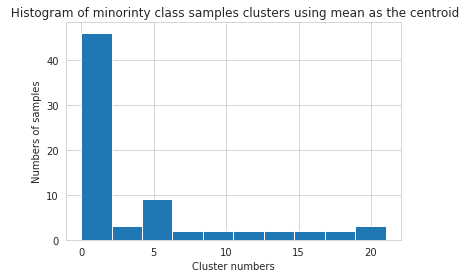

In [78]:
plt.hist(labels)
plt.title(" Histogram of minorinty class samples clusters using mean as the centroid")
plt.xlabel("Cluster numbers")
plt.ylabel("Numbers of samples")

In [79]:
X_min = np.array(X_min.values.tolist())
X_min

array([[0.09259259, 0.4375    , 0.05617978],
       [0.2037037 , 0.22916667, 0.04494382],
       [0.55555556, 0.64583333, 0.08988764],
       [0.59259259, 0.22916667, 0.13483146],
       [0.77777778, 0.75      , 0.05617978],
       [0.37037037, 0.95833333, 0.06741573],
       [0.37037037, 0.5       , 0.19101124],
       [0.35185185, 0.22916667, 0.05617978],
       [0.55555556, 0.22916667, 0.05617978],
       [0.11111111, 0.0625    , 0.17977528],
       [0.14814815, 0.33333333, 0.12359551],
       [0.09259259, 0.22916667, 0.05617978],
       [0.35185185, 0.125     , 0.21348315],
       [0.83333333, 0.95833333, 0.07865169],
       [0.46296296, 0.33333333, 0.12359551],
       [0.77777778, 0.33333333, 0.07865169],
       [0.87037037, 0.5       , 0.04494382],
       [0.37037037, 0.125     , 0.02247191],
       [0.46296296, 0.125     , 0.24719101],
       [0.18518519, 0.54166667, 0.20224719],
       [0.59259259, 0.22916667, 0.05617978],
       [0.55555556, 0.125     , 0.1494382 ],
       [0.

In [80]:
# do the sampling
samples = []
while len(samples) < n_to_sample:
  idx = random_state.choice(np.arange(len(X_min)), p=weights)
  if len(clusters[labels[idx]]) <= 1:
      samples.append(X_min[idx])
      continue
  else:
    random_idx = random_state.choice(clusters[labels[idx]])
    while random_idx == idx:
      random_idx = random_state.choice(clusters[labels[idx]])  
    samples.append(sample_between_points(X_min[idx], X_min[random_idx]))                  

X_generated = np.vstack([X, np.vstack(samples)])
y_generated = np.hstack([y, np.repeat(min_label, len(samples))])

In [81]:
# Obtaining the new training dataset with artificial samples
X_train_new = pd.DataFrame(data=X_generated, columns=["age", "ejection_fraction", "serum_creatinine"])
print(X_train_new)

y_train_new = pd.DataFrame(data=y_generated, columns=["class"]).values.ravel()
print(y_train_new)
print(y_train_new.shape)	

          age  ejection_fraction  serum_creatinine
0    0.759259           0.437500          0.076404
1    0.185185           0.333333          0.022472
2    0.092593           0.437500          0.056180
3    0.222222           0.500000          0.056180
4    0.185185           0.541667          0.033708
..        ...                ...               ...
327  0.806417           0.387033          0.067067
328  0.359276           0.314095          0.060330
329  0.370370           0.958333          0.067416
330  0.483343           0.229167          0.156927
331  0.430491           0.155442          0.191369

[332 rows x 3 columns]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

In [82]:
# Generate CSV files to be used in Custom SVM
pd.DataFrame(X_train_new).to_csv("X_train_new.csv")
pd.DataFrame(y_train_new).to_csv("y_train_new.csv")

## Training the model


### SVM model

In [83]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[0.1, 1, 10,100],'gamma':[0.1, 1, 10] }
svc = svm.SVC(random_state=0)
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_new, y_train_new)
y_pred_SVM_CV = clf.predict(X_test)

print("Using the score funtion:",clf.score(X_test,y_test))
print("The best param is:", clf.best_params_)

cm = confusion_matrix(y_test, y_pred_SVM_CV)
print(cm)
print("Accuracy Score:",accuracy_score(y_test, y_pred_SVM_CV))
print("F1 score:",f1_score(y_test, y_pred_SVM_CV, average='macro'))
print("MCC Score:",matthews_corrcoef(y_test, y_pred_SVM_CV))

Using the score funtion: 0.7666666666666667
The best param is: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
[[31  6]
 [ 8 15]]
Accuracy Score: 0.7666666666666667
F1 score: 0.7488038277511961
MCC Score: 0.49949290539169905


### Neural network

In [84]:
#Trying Neural Networks (multilayer perceptron)
from sklearn.neural_network import MLPClassifier
maxScore = 0
maxi = 0
maxj = 0
for i in range(2,6):
    for j in range(2,6):
        clf_nn = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(i,j),random_state = 1)
        clf_nn.fit(X_train_new, y_train_new)#,batch_size=57, epochs=1000, validation_split=0.2)
        y_pred_nn = clf_nn.predict(X_test)
        print("*"*20)
#         print(clf_nn.loss_)
        print("loss = %f" %(clf_nn.loss_))



        cm = confusion_matrix(y_test, y_pred_nn)
        print("This is when the layer sizes is: %i,%i" %(i,j))
        print(cm)
        Score = accuracy_score(y_test, y_pred_nn)
        print(Score)
        if (Score > maxScore):
            maxScore= Score
            maxi = i
            maxj = j
        print("F1 score:",f1_score(y_test, y_pred_nn, average='macro'))
        print("MCC Score:",matthews_corrcoef(y_test, y_pred_nn))
print("the best score was when the layer size was: %i,%i with a score of %04f" %(maxi,maxj,maxScore))


********************
loss = 0.693147
This is when the layer sizes is: 2,2
[[37  0]
 [23  0]]
0.6166666666666667
F1 score: 0.3814432989690722
MCC Score: 0.0
********************
loss = 0.693147
This is when the layer sizes is: 2,3
[[ 0 37]
 [ 0 23]]
0.38333333333333336
F1 score: 0.27710843373493976
MCC Score: 0.0
********************
loss = 0.693147
This is when the layer sizes is: 2,4
[[37  0]
 [23  0]]
0.6166666666666667
F1 score: 0.3814432989690722
MCC Score: 0.0
********************
loss = 0.693147
This is when the layer sizes is: 2,5
[[ 0 37]
 [ 0 23]]
0.38333333333333336
F1 score: 0.27710843373493976
MCC Score: 0.0
********************
loss = 0.693147
This is when the layer sizes is: 3,2
[[ 0 37]
 [ 0 23]]
0.38333333333333336
F1 score: 0.27710843373493976
MCC Score: 0.0
********************
loss = 0.561504
This is when the layer sizes is: 3,3
[[31  6]
 [ 7 16]]
0.7833333333333333
F1 score: 0.7688888888888887
MCC Score: 0.5382548280972278


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


********************
loss = 0.553930
This is when the layer sizes is: 3,4
[[32  5]
 [11 12]]
0.7333333333333333
F1 score: 0.7
MCC Score: 0.4171309643104571
********************
loss = 0.693145
This is when the layer sizes is: 3,5
[[ 1 36]
 [ 2 21]]
0.36666666666666664
F1 score: 0.28750000000000003
MCC Score: -0.13369259122787552
********************
loss = 0.693147
This is when the layer sizes is: 4,2
[[ 0 37]
 [ 0 23]]
0.38333333333333336
F1 score: 0.27710843373493976
MCC Score: 0.0
********************
loss = 0.693147
This is when the layer sizes is: 4,3
[[ 0 37]
 [ 0 23]]
0.38333333333333336
F1 score: 0.27710843373493976
MCC Score: 0.0
********************
loss = 0.557349
This is when the layer sizes is: 4,4
[[31  6]
 [11 12]]
0.7166666666666667
F1 score: 0.6850879901204076
MCC Score: 0.38150105974497217
********************
loss = 0.596212
This is when the layer sizes is: 4,5
[[30  7]
 [ 6 17]]
0.7833333333333333
F1 score: 0.7726610317691636
MCC Score: 0.5457882752158589
**********

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


F1 score: 0.7532314923619272
MCC Score: 0.5064629847238543
********************
loss = 0.565770
This is when the layer sizes is: 5,3
[[30  7]
 [ 6 17]]
0.7833333333333333
F1 score: 0.7726610317691636
MCC Score: 0.5457882752158589
********************
loss = 0.563325
This is when the layer sizes is: 5,4
[[31  6]
 [ 6 17]]
0.8
F1 score: 0.7884841363102232
MCC Score: 0.5769682726204466
********************
loss = 0.542983
This is when the layer sizes is: 5,5
[[31  6]
 [ 8 15]]
0.7666666666666667
F1 score: 0.7488038277511961
MCC Score: 0.49949290539169905
the best score was when the layer size was: 5,4 with a score of 0.800000


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Random Forest 

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV


calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=20))


pipe = Pipeline([('select', SelectKBest()),('model', calibrated_forest)])
param_grid = {'select__k': [1, 2],'model__base_estimator__max_depth': [2, 4, 6, 8]}



search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_new, y_train_new)
y_pred_Pipe = search.predict(X_test)


print("Using the score funtion:",search.score(X_test,y_test))
print("The best param is:", search.best_params_)

cm = confusion_matrix(y_test, y_pred_Pipe)
print(cm)
print("Accuracy Score:",accuracy_score(y_test, y_pred_Pipe))
print("F1 score:",f1_score(y_test, y_pred_Pipe, average='macro'))
print("MCC Score:",matthews_corrcoef(y_test, y_pred_Pipe))


Using the score funtion: 0.7166666666666667
The best param is: {'model__base_estimator__max_depth': 8, 'select__k': 2}
[[30  7]
 [10 13]]
Accuracy Score: 0.7166666666666667
F1 score: 0.6919359710057384
MCC Score: 0.3878289324509757


### Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'), 'C':[0.1, 1, 10,100],'fit_intercept':[True,False]}
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters)
clf = clf.fit(X_train_new, y_train_new)
y_pred=clf.predict(X_test)
print("Using the score funtion:",clf.score(X_test,y_test))
print("The best param is:", clf.best_params_)
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='macro'))
print("MCC Score:",matthews_corrcoef(y_test, y_pred))

#print(y_pred)
#print(accuracy_score(y_test, y_pred))
#print(clf.predict_proba(X_test))
#plt.figure(figsize=(10, 10))
#plt.scatter(clf.predict_proba(X_test)[:,1],y_pred)
#plt.scatter(clf.predict_proba(X_train)[:,1],y_train)



Using the score funtion: 0.7666666666666667
The best param is: {'C': 100, 'fit_intercept': False, 'solver': 'newton-cg'}
[[29  8]
 [ 6 17]]
Accuracy Score: 0.7666666666666667
F1 score: 0.7569444444444444
MCC Score: 0.5156929620972371


### Naive Bayes

In [87]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train_new, y_train_new).predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred)
print(cm_nb)
print("Accuracy Score:",accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='macro'))
print("MCC Score:",matthews_corrcoef(y_test, y_pred))

[[34  3]
 [12 11]]
Accuracy Score: 0.75
F1 score: 0.7069358515141647
MCC Score: 0.45657169762696875
